In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import shuffle
from skmultiflow.drift_detection.adwin import ADWIN
import math

cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\__init__.py
normal_accessor
normal_accessor
pathobj C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\matplotlibrc
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
pathobj C:\Users\Terry\.matplotlib
pathobj C:\Users\Terry\.matplotlib
pathobj C:\Users\Terry\.matplotlib
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls 

# iForest ADWIN

In [3]:
class Node:
    def __init__(self,internal=True,left=None,right=None,sAtt=None,sVal=None,size=None):
        self.internal = internal
        self.size = size
        self.left = left
        self.right = right
        self.sAtt = sAtt
        self.sVal = sVal
        return
            

In [4]:
def c(n):
#     print('3333',n)
    return 2*H(n-1)-(2*(n-1)/n)

def H(i):
    return math.log(i)+0.5772156649

In [5]:
class iTree:
    def __init__(self,X,e,l,X_cati=None):
        """
        INPUTS:
        X: input data
        e: current tree height
        l: height limit

        OUTPUT:
        """
        self.X = X
        self.l = l
        self.root = self.build(X,e,l,X_cati)
        return

    def build(self,X,e,l,X_cati=None):
#         print('e:',e,'l：',l)
        if e>=l or len(X)<=1:
#             print(e)
            return Node(internal=False,size=len(X))
        else:
            q = random.randint(0,len(X[0])-1)
            if X_cati and X_cati[q]:
                p = random.choice(list(set(X[:,q])))
                Xl = X[X[:,q]==p]
                Xr = X[X[:,q]!=p]
                return Node(internal=True,
                            left=self.build(Xl,e+1,l,X_cati),
                            right=self.build(Xr,e+1,l,X_cati),
                            sAtt=q,
                            sVal=p)
            else:
                p = random.uniform(min(X[:,q]),max(X[:,q]))
                Xl = X[X[:,q]<p]
                Xr = X[X[:,q]>=p]
                return Node(internal=True,
                            left=self.build(Xl,e+1,l,X_cati),
                            right=self.build(Xr,e+1,l,X_cati),
                            sAtt=q,
                            sVal=p)
            
    def pathLength(self,x,N=None,e=0,X_cati=None):
        """
        INPUTS:
        x: an instance
        N: a Node in the iTree
        e: current path length
        """
        if not N:
            N = self.root
        if not N.internal:
            if N.size>1:
#                 print(1)
                return e+(N.size>1)*c(N.size)
            else:
#                 print(0)
                return e
        a = N.sAtt
        if X_cati and X_cati[a]:
            if x[a] == N.sVal:
                return self.pathLength(x,N.left,e+1,X_cati)
            else:
                return self.pathLength(x,N.right,e+1,X_cati)
        else:
            if x[a] < N.sVal:
                return self.pathLength(x,N.left,e+1,X_cati)
            else:
                return self.pathLength(x,N.right,e+1,X_cati)
        
    def draw(self):
        if len(self.X[0])!=2:
            print('iTree.draw() function only support 2D data')
            return
        plt.figure()
        plt.scatter(self.X[:,0],self.X[:,1])
        limits = [[min(self.X[:,0]),max(self.X[:,0])],[min(self.X[:,1]),max(self.X[:,1])]]
        self._helper(self.root,limits)
                
    def _helper(self,node,limits):
        if not node.internal:
            return
        att = node.sAtt
        val = node.sVal
        point1 = [(1-att)*val+att*limits[1-att][0],att*val+(1-att)*limits[1-att][0]]
        point2 = [(1-att)*val+att*limits[1-att][1],att*val+(1-att)*limits[1-att][1]]
        plt.plot([point1[0],point2[0]],[point1[1],point2[1]])
        limitL = [[limits[0][0],(1-att)*val+att*limits[0][1]],[limits[1][0],(1-att)*limits[1][1]+att*val]]
        limitR = [[(1-att)*val+att*limits[0][0],limits[0][1]],[(1-att)*limits[1][0]+att*val,limits[1][1]]]
        self._helper(node.left,limitL)
        self._helper(node.right,limitR)

In [6]:
import math
import random
class iForest:
    def __init__(self,X,t,phi,X_cati=None):
        """
        INPUTS:
        X: input data
        X_type: list of data type in each dimension of X
        t: number of trees
        phi: subsampling size
        
        OUTPUT:
        Forest: a set of t iTrees
        """
        self.size = t
        self.n = phi
        self.forest = []
        self._Train(X,t,phi,X_cati)
        return
        
    def _Train(self,X,t,phi,X_cati):
        # l: height limit of iTrees
        l = math.ceil(math.log2(phi))
#         l = phi/2
#         l = min(math.ceil(math.log2(phi))*2,phi/2)
        for i in range(t):
            # X_prime: subsample of X, used for training the ith iTree
            X_prime = X[np.random.choice(X.shape[0], phi, replace=False), :]
#             print(X_prime.shape)
            self.forest.append(iTree(X_prime,0,l,X_cati))
    
    def predict(self,x):
        h_sum = 0
        for i in range(self.size):
#             print(self.forest[i].pathLength(x))
            h_sum += self.forest[i].pathLength(x)
        E = h_sum/self.size
#         print('E',E)
#         print('c',c(self.n))
        return 2**(-E/c(self.n))
        

In [7]:
class ADWIN1:
    def __init__(self,delta=0.02,min_win_size=50,max_size=250):
        self.W = []
        self.delta = delta
        self.min_win_size = min_win_size
        self.max_size = max_size
        self.change = False
        
    
    def add_element(self,x):
        if len(self.W)>=self.max_size:
            del self.W[0]
        self.change = False
        self.W.append(x)
        while len(self.W)>1 and self.driftTest():
            self.change = True
            del self.W[0]
            
    def detected_change(self):
        return self.change
            
    def driftTest(self):
        for i in range(1,len(self.W)-1):
            W0 = self.W[:i]
            W1 = self.W[i:]
            n0 = len(W0)
            n1 = len(W1)
            n = len(self.W)
#             print('n0',n0,'n1',n1)
            m = 1/(1/n0+1/n1)
            delta_prime = self.delta/n
            epsilon_cut = (1/(2*m)*np.log(4/delta_prime))**(1/2)
            mu0 = np.mean(W0)
            mu1 = np.mean(W1)
            if abs(mu0-mu1)>=epsilon_cut:
                return True
        return False
            
        

In [8]:
class MADWIN:
    def __init__(self,delta=0.02,min_win_size=50,max_size=250):
        self.W = []
        self.delta = delta
        self.min_win_size = min_win_size
        self.max_size = max_size
        self.change = False
        self.min_i = 0
        self.max_i = 0
        
    
    def add_element(self,x):
        if len(self.W)>=self.max_size:
            del self.W[0]
            self.min_i += 1
        self.change = False
        self.W.append(x)
        self.max_i += 1
        while len(self.W)>1 and self.driftTest():
            self.change = True
            del self.W[-1]
            self.max_i -= 1
            
    def detected_change(self):
        ans = self.change
        self.change = False
        return ans
            
    def driftTest(self):
        for i in range(self.min_win_size,len(self.W)-self.min_win_size):
            W0 = self.W[:i]
            W1 = self.W[i:]
            n0 = len(W0)
            n1 = len(W1)
            n = len(self.W)
#             print('n0',n0,'n1',n1)
            m = 1/(1/n0+1/n1)
            delta_prime = self.delta/n
            epsilon_cut = (1/(2*m)*np.log(4/delta_prime))**(1/2)
            mu0 = np.mean(W0)
            mu1 = np.mean(W1)
            if abs(mu0-mu1)>=epsilon_cut:
                return True
        return False
            
        

In [9]:
class Detector:
    def __init__(self,t,phi,delta=0.02,min_win_size=50):
        """
        INPUTS:
        t: iforest number of trees
        phi: iforest subsampling size
        delta: adwin threshold
        min_win_size: adwin minimal window size
        """
        self.t = t
        self.phi = phi
        self.delta = delta
        self.selector = VarianceThreshold()
        self.madwin = MADWIN(delta=self.delta)
        self.feature_filter = None
        self.iforest = None
        self.prediction = []
        return
    
    def train(self,X):
        X_prime = self.selector.fit_transform(X)
        self.feature_filter = self.selector.get_support()
        self.iforest = iForest(X_prime, self.t, self.phi)
        return
    
    def predict(self,x):
        x = x.reshape((1,-1))
        xp = self.selector.transform(x)
        xp = xp.reshape((-1,))
        s = self.iforest.predict(xp)
        self.madwin.add_element(s*4)
        if self.madwin.detected_change():
            self.prediction.append(-1)
            return -1
        self.prediction.append(s)
        return s

In [10]:
class algorithm:
    def __init__(self,e,window_size,t,phi,delta=0.02,min_win_size=50,thresh=0.7):
        """
        INPUT:
        e: number of detectors
        window_size: buffer size
        t: iforest number of trees
        phi: iforest subsampling size
        delta: adwin threshold
        min_win_size: adwin minimal window size
        thresh: abnormal threshold
        """
        self.e = e
        self.window_size = window_size
        self.t = t
        self.phi = phi
        self.delta = delta
        self.thresh = thresh
        self.min_win_size = min_win_size
        self.selector = VarianceThreshold()
        self.previous_window = []
        self.current_window = []
        self.ensemble = []
        
        self.ind = 0
        return
    
    def predict(self,x):
        output = []
        s_output = []
        e_index = []
        self.current_window.append(x)
        if len(self.current_window)==self.window_size:
            self.previous_window = self.current_window
            self.current_window = []
            # feature selection:
            self.selector.fit(self.previous_window)
            feature_filter = self.selector.get_support()
            if self._feature_drift_detection(feature_filter) or len(self.ensemble)==0:
                # feature drift occurs OR no existing detector in ensemble
                detector = Detector(self.t,self.phi,self.delta,self.min_win_size)
#                 print('Add new detector because feature drift')
                detector.train(self.previous_window)
                if len(self.ensemble)>=self.e:
                    del self.ensemble[0]
                self.ensemble.append(detector)
                output = [1]*len(self.previous_window)
                s_output = [1]*len(self.previous_window)
                e_index = [0]*len(self.previous_window)
                return output,s_output,e_index
            else:
                for sample in self.previous_window:
                    scores = np.zeros((len(self.ensemble),))
                    for i in range(len(self.ensemble)):
                        detector = self.ensemble[i]
                        s = -1
                        if np.array_equal(detector.feature_filter,feature_filter):
                            s = detector.predict(sample)
                            scores[i] = s
                    valid_scores = scores[scores>0]
                    if len(valid_scores)>0:
#                         print(scores)
                        score = np.max(valid_scores)
                        index = np.where(scores==score)[0][0]+1
                        s_output.append(score)
                        e_index.append(index)
                        if score>self.thresh:
                            output.append(0)
                        else:
                            output.append(1)
                    else:
                        detector = Detector(self.t,self.phi,self.delta,self.min_win_size)
#                         print('Add new detector because concept drift')
#                         print('scores',scores)
                        detector.train(self.previous_window)
                        if len(self.ensemble)>=self.e:
                            del self.ensemble[0]
                        self.ensemble.append(detector)
                        output = [1]*len(self.previous_window)
                        s_output = [1]*len(self.previous_window)
                        e_index = [0]*len(self.previous_window)
                        return output,s_output,e_index
        return output,s_output,e_index
        
    def _feature_drift_detection(self,feature_filter):
        for detector in self.ensemble:
            if np.array_equal(detector.feature_filter,feature_filter):
                return False
        return True
        

In [11]:
class iForestADWIN:
    def __init__(self,train_size,t,phi,X_cati=None,thresh=0.7,text=False,delta=0.02,min_win_size=50):
        self.i = 0
        self.train_size = train_size
        self.t = t
        self.phi = phi
        self.X_cati = X_cati
        self.forest = None
        self.delta = delta
        self.min_win_size = min_win_size
        self.adwin = ADWIN1(delta=delta,min_win_size=self.min_win_size)
        self.train_data = []
        self.score = []
        self.prediction = []
        self.train_state = True 
        self.anomaly = 0
        self.text = text
        self.thresh = thresh
        self.feature_filter = None
        return
    
    def train(self):
        self.train_data = np.array(self.train_data)
        selector = VarianceThreshold()
        self.train_data = selector.fit_transform(self.train_data)
#         print(self.train_data.shape)
        self.forest = iForest(self.train_data, self.t, self.phi, self.X_cati)
#         return
        return selector.get_support()
    
    def retrain(self):
        self.forest = None
        self.adwin = ADWIN1(delta=self.delta,min_win_size=self.min_win_size)
        self.train_data = []
        self.train_state = True
        return
    
    def add_element(self,x):
        if len(self.train_data)<self.train_size:
            self.score.append(1)
            self.prediction.append(1)
            self.train_data.append(x)
        elif len(self.train_data)==self.train_size and self.train_state:
            self.score.append(1)
            self.prediction.append(1)
            self.feature_filter = self.train()
            self.train_state = False
        else:
            x = [x[i] for i in range(len(x)) if self.feature_filter[i]]
#             print(x)
            predict = self.forest.predict(x)
#             print(predict)
            self.score.append(predict)
            self.adwin.add_element(predict*4)
            if self.adwin.detected_change():
                if self.text:
                    print('Change detected:',x,'index',self.i)
                self.prediction.append(1)
                self.retrain()
            else:
                if predict>self.thresh:
                    self.prediction.append(0)
                    self.anomaly += 1
                    if self.text:
                        print('Anomaly detected:',x,'index',self.i)
                else:
                    self.prediction.append(1)
        self.i += 1
        return
        
        

In [12]:
def segment_generate(means,variances,length,biases,ratio,zeros):
    stream = np.zeros((len(means),length))
    indexs = np.random.choice(length,size=int(length*ratio),replace=False)
    label = np.ones((length,))
    for i in indexs:
        label[i] = 0
    for d in range(len(means)):
        if d not in zeros:
            mean = means[d]
            var = variances[d]
            bias = biases[d]
            stream[d] = np.random.normal(mean,var,length)
            for i in indexs:
                stream[d,i] = np.random.normal(mean,var+5)
    return stream.T,label

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [14]:
def evaluation(prediction,s_prediction,label):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(label)):
        if prediction[i]!=0 and label[i]==1:
            TP += 1
        elif prediction[i]!=0 and label[i]==0:
            FP += 1
        elif prediction[i]==0 and label[i]==1:
            FN += 1
        else:
            TN += 1
    ACC = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP) if TP>0 else 0
    Recall = TP/(TP+FN) if TP>0 else 0
    F1 = 2*Precision*Recall/(Precision+Recall) if Precision>0 and Recall>0 else 0
    FPR = FP/(FP+TN) if FP>0 else 0
    TPR = TP/(TP+FN) if TP>0 else 0
    print('TP:',TP,'TN:',TN,'FP:',FP,'FN:',FN)
    print('ACC:',ACC,'Precision:',Precision,'Recall:',Recall,'F1:',F1)
    print('FPR:',FPR,'TPR:',TPR)
    tpr,fpr,thresholds = roc_curve(label,s_prediction,pos_label=1)
#     print('thresholds:',thresholds)
    AUC = auc(fpr,tpr)
    print('AUC:',AUC)
    plt.figure()
    plt.plot(fpr,tpr)
    plt.show()
    return [TP,TN,FP,FN,ACC,Precision,Recall,F1,FPR,TPR,AUC]

# Generate Simulated Data Stream

(0, 10)
(3000, 10)
(3000,)


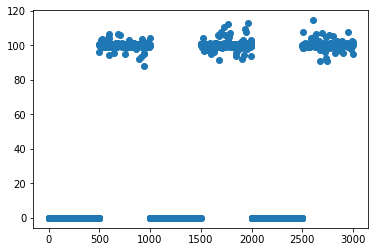

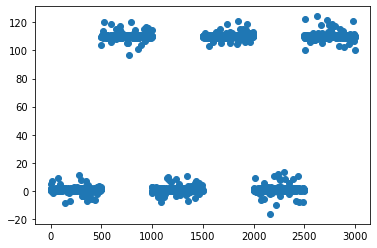

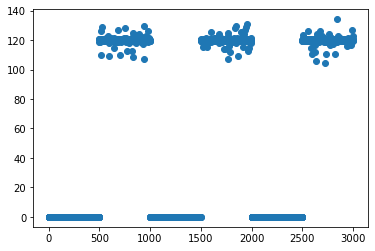

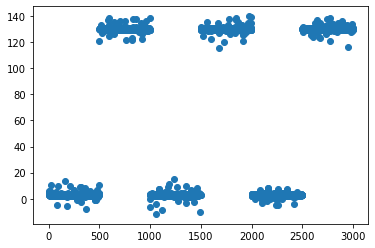

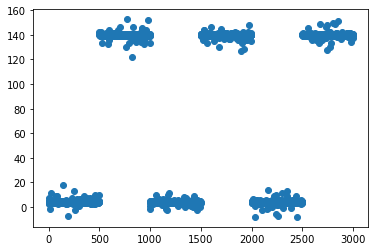

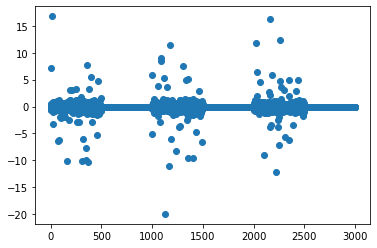

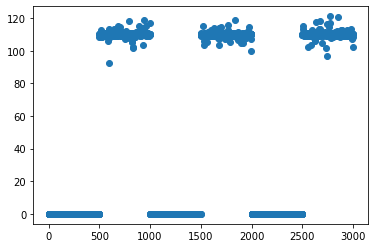

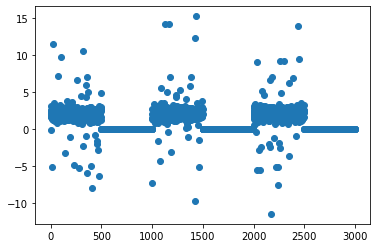

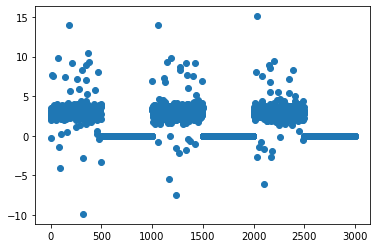

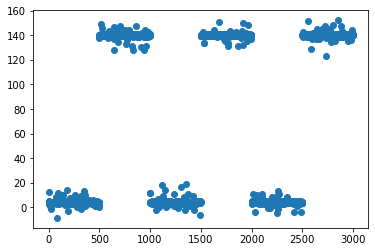

In [15]:
means = [[0,1,2,3,4,0,1,2,3,4],[100,110,120,130,140,100,110,120,130,140]]
variances = [[.5,.5,.5,.5,.5,.5,.5,.5,.5,.5],[.5,.5,.5,.5,.5,.5,.5,.5,.5,.5]]
length = 500
biases = [[20]*10,[20]*10]
zeros = [[0,2,6],[5,7,8]]
stream = np.array([]).reshape((-1,10))
label = np.array([])
print(stream.shape)
for i in range(6):
    s,l = segment_generate(means[i%2],variances[i%2],length,biases[i%2],0.07,zeros[i%2])
    stream = np.concatenate((stream,s),axis=0)
    label = np.concatenate((label,l),axis=0)
print(stream.shape)
print(label.shape)
for d in range(len(stream[1])):
    plt.figure()
    plt.scatter(range(length*6),stream[:,d])
    plt.show()

# Experiment Execution

**********
window_size: 20
t: 75
phi: 15
thresh: 0.5
time used:9.749866485595703
TP: 2187 TN: 208 FP: 2 FN: 603
ACC: 0.7983333333333333 Precision: 0.9990863407948835 Recall: 0.7838709677419354 F1: 0.8784896565575416
FPR: 0.009523809523809525 TPR: 0.7838709677419354
AUC: 0.9845553848779656


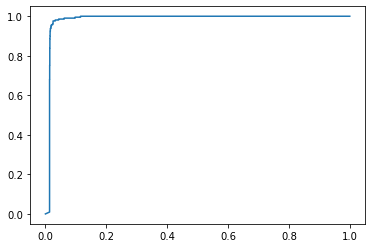

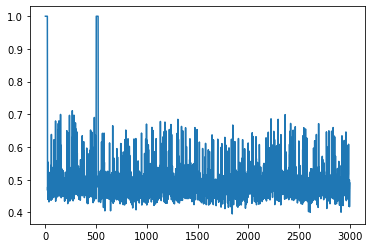

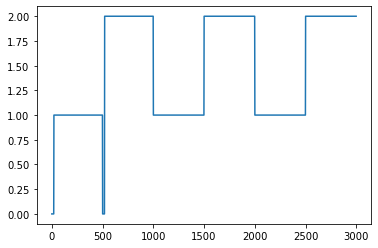

time used:13.967702388763428
TP: 1859 TN: 204 FP: 6 FN: 931
ACC: 0.6876666666666666 Precision: 0.9967828418230563 Recall: 0.6663082437275986 F1: 0.7987110633727176
FPR: 0.02857142857142857 TPR: 0.6663082437275986
AUC: 0.9341790407919441


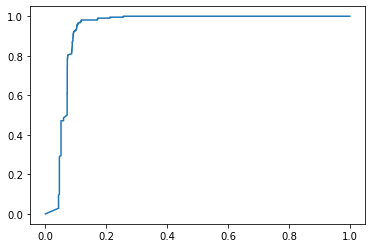

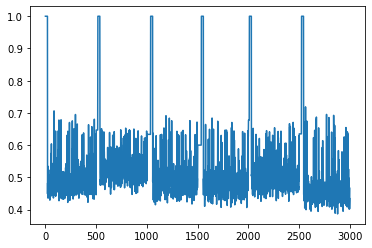

**********
window_size: 50
t: 75
phi: 37
thresh: 0.5
time used:9.645771980285645
TP: 2366 TN: 208 FP: 2 FN: 424
ACC: 0.858 Precision: 0.9991554054054054 Recall: 0.8480286738351255 F1: 0.9174098487785962
FPR: 0.009523809523809525 TPR: 0.8480286738351255
AUC: 0.9649291688001365


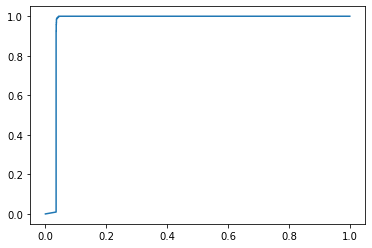

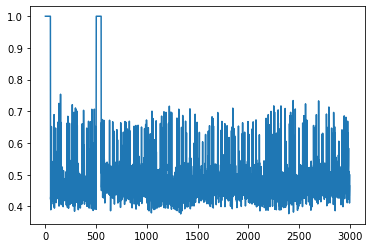

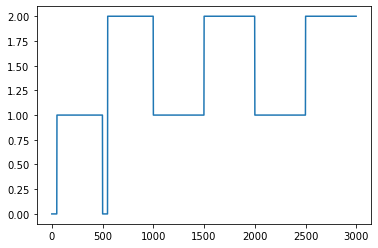

time used:14.255964517593384
TP: 2665 TN: 192 FP: 18 FN: 125
ACC: 0.9523333333333334 Precision: 0.9932910920611256 Recall: 0.9551971326164874 F1: 0.9738717339667459
FPR: 0.08571428571428572 TPR: 0.9551971326164874
AUC: 0.8943522785458269


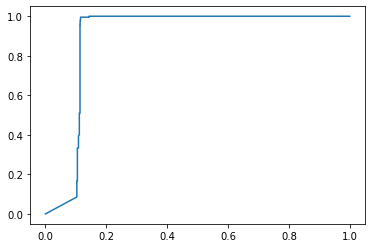

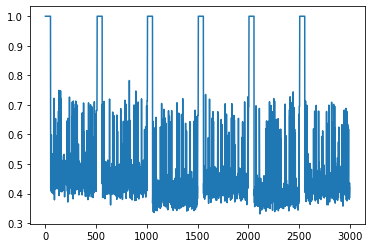

total time: 48.38701510429382 s


In [40]:
# window_size_list = list(range(10,1000,50))
# t_list = list(range(10,100,20))
# phi_list = list(range(int(window_size/10),window_size,int(window_size/10)))
# thresh_list = [0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]
import time
window_size_list = np.array([20,30,50,100])
t_list = np.array([20,50,75,100])
phi_list = np.array([0.1,0.25,0.5,0.75,0.9])
thresh_list = np.array([0.45,0.475,0.5,0.55,0.6,0.7])

# np.save("configs/window_size_list_4.npy",window_size_list)
# np.save("configs/t_list_4.npy",t_list)
# np.save("configs/phi_list_4.npy",phi_list)
# np.save("configs/thresh_list_4.npy",thresh_list)

window_size_list = [20,50]
t_list = [75]
phi_list = [0.75]
thresh_list = [0.5]

results = np.zeros((len(window_size_list),
                    len(t_list),
                    len(phi_list),
                    len(thresh_list),
                    2,
                    12))
start = time.time()
for aa in range(len(window_size_list)):
    window_size = window_size_list[aa]
    for bb in range(len(t_list)):
        t = t_list[bb]
        for cc in range(len(phi_list)):
            phi = int(phi_list[cc]*window_size)
            for dd in range(len(thresh_list)):
                thresh = thresh_list[dd]
                
                print('*'*10)
                print('window_size:',window_size)
                print('t:',t)
                print('phi:',phi)
                print('thresh:',thresh)
                
                detector = algorithm(e=10,
                                     window_size=window_size,
                                     t=t,
                                     phi=phi,
                                     delta=0.02,
                                     min_win_size=5,
                                     thresh=thresh)
                prediction = []
                s_prediction = []
                e_indexs = []
                tic = time.time()
                for i in range(len(stream)):
                    x = stream[i]
                    output,ss,e_index = detector.predict(x)
                    prediction += output
                    s_prediction += ss
                    e_indexs += e_index
#                     e_num.append(len(detector.ensemble))
                    print(str(aa*len(t_list)*len(phi_list)*len(thresh_list)
                              +bb*len(phi_list)*len(thresh_list)
                              +cc*len(thresh_list)
                              +dd)+'/'
                            +str(len(window_size_list)
                               *len(t_list)
                               *len(phi_list)
                               *len(thresh_list))
                          +' '
                          +str(i)+'/'+str(len(stream)),end='\r')
                toc = time.time()
                print('time used:'+str(toc-tic))
                
                res = evaluation(prediction,s_prediction,label[:len(prediction)])
                res.append(toc-tic)
                
                plt.figure()
                plt.plot(s_prediction)
                plt.show()
                
                plt.figure()
                plt.plot(e_indexs)
                plt.show()
                
                results[aa,bb,cc,dd,0] = np.array(res)
#                 for e in range(len(detector.ensemble)):
#                     plt.figure()
#                     plt.plot(detector.ensemble[e].prediction)
#                     plt.show()
                
    
    
    
    
    
    
    
    
                detector = iForestADWIN(train_size=window_size,
                                     t=t,
                                     phi=phi,
                                     delta=0.02,
                                     min_win_size=5,
                                     thresh=thresh)
                prediction = []
                tic = time.time()
                for i in range(len(stream)):
                    x = stream[i]
                    detector.add_element(x)
                    print(str(aa*len(t_list)*len(phi_list)*len(thresh_list)
                              +bb*len(phi_list)*len(thresh_list)
                              +cc*len(thresh_list)
                              +dd)+'/'
                            +str(len(window_size_list)
                               *len(t_list)
                               *len(phi_list)
                               *len(thresh_list))
                          +' '
                          +str(i)+'/'+str(len(stream)),end='\r')
                prediction = detector.prediction
                s_prediction = detector.score
                toc = time.time()
                print('time used:'+str(toc-tic))
                
                res = evaluation(prediction,s_prediction,label[:len(prediction)])
                res.append(toc-tic)
                plt.figure()
                plt.plot(s_prediction)
                plt.show()
                results[aa,bb,cc,dd,1] = np.array(res)
end = time.time()
# np.save("results/results_4.npy",results)
print('total time:',end-start,'s')


# Load Saved Results

In [30]:
results = np.load('results/results_4.npy')
window_size_list = np.load('configs/window_size_list_4.npy')
t_list = np.load('configs/t_list_4.npy')
phi_list = np.load('configs/phi_list_4.npy')
thresh_list = np.load('configs/thresh_list_4.npy')

# Generate Latex Table

In [31]:
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        print('\\begin{table}[h]')
        print('\\centering')
        print('\\begin{tabular}{| p{1cm} p{1cm} p{1cm} p{1cm} || p{1.75cm} p{1.5cm} || p{1.75cm} p{1.5cm} | p{1cm} |}')
        print('\\hline')
        print('Buf Size & Trees & samp ratio & thresh & SAd $F_1$ & SAd AUC & PCF $F_1$ & PCF AUC & Time Ratio\\\\')
        print('\\hline')
        
        for cc in range(results.shape[2]):
            print('\\hline')
            for dd in range(results.shape[3]):
                f1a = np.round(results[aa,bb,cc,dd,1,7]*100,decimals=2)
                f1b = np.round(results[aa,bb,cc,dd,0,7]*100,decimals=2)
                auca = np.round(results[aa,bb,cc,dd,1,10],decimals=2)
                aucb = np.round(results[aa,bb,cc,dd,0,10],decimals=2)
                rt = np.round(results[aa,bb,cc,dd,0,11]/results[aa,bb,cc,dd,1,11],decimals=2)
                print(window_size_list[aa],'&',
                      t_list[bb],'&',
                      phi_list[cc],'&',
                      thresh_list[dd],'&',
                      (f1a>f1b)*'\\textbf{',f1a,(f1a>f1b)*'}','\% &',
                      (auca>aucb)*'\\textbf{',auca,(auca>aucb)*'}',' &',
                      (f1a<=f1b)*'\\textbf{',f1b,(f1a<=f1b)*'}','\% &',
                      (auca<=aucb)*'\\textbf{',aucb,(auca<=aucb)*'}',' &',
                      (rt<1)*'\\textbf{',rt,(rt<1)*'}','\\\\')
        print('\\hline')
        print('\\end{tabular}')
        index = str(aa*results.shape[1]+bb)
        print('\\caption{\label{tab:Simulated data set results '+ index +' }Simulated data set results ' + index+  ' for comparison between SADWIN IFA(SAd) and PCFDAD(PCF).}')
        print('\\end{table}')
        print()

\begin{table}[h]
\centering
\begin{tabular}{| p{1cm} p{1cm} p{1cm} p{1cm} || p{1.75cm} p{1.5cm} || p{1.75cm} p{1.5cm} | p{1cm} |}
\hline
Buf Size & Trees & samp ratio & thresh & SAd $F_1$ & SAd AUC & PCF $F_1$ & PCF AUC & Time Ratio\\
\hline
\hline
20 & 20 & 0.1 & 0.45 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.56 } \\
20 & 20 & 0.1 & 0.475 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.56 } \\
20 & 20 & 0.1 & 0.5 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.56 } \\
20 & 20 & 0.1 & 0.55 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.56 } \\
20 & 20 & 0.1 & 0.6 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.56 } \\
20 & 20 & 0.1 & 0.7 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.56 } \\
\hline
20 & 20 & 0.25 & 0.45 &  9.75  \% &  0.77   & \textbf{ 15.44 } \% & \textbf{ 0.91 }  & \textbf{ 0.56 } \\
20 & 20 & 0.25 &

C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


30 & 20 & 0.75 & 0.5 & \textbf{ 97.48 } \% &  0.93   &  88.68  \% & \textbf{ 0.96 }  & \textbf{ 0.62 } \\
30 & 20 & 0.75 & 0.55 &  98.8  \% &  0.93   & \textbf{ 99.15 } \% & \textbf{ 0.97 }  & \textbf{ 0.64 } \\
30 & 20 & 0.75 & 0.6 &  98.38  \% &  0.93   & \textbf{ 98.84 } \% & \textbf{ 0.97 }  & \textbf{ 0.61 } \\
30 & 20 & 0.75 & 0.7 & \textbf{ 96.6 } \% &  0.93   &  96.51  \% & \textbf{ 0.97 }  & \textbf{ 0.62 } \\
\hline
30 & 20 & 0.9 & 0.45 & \textbf{ 89.46 } \% &  0.93   &  76.75  \% & \textbf{ 0.97 }  & \textbf{ 0.61 } \\
30 & 20 & 0.9 & 0.475 & \textbf{ 96.15 } \% &  0.93   &  89.78  \% & \textbf{ 0.97 }  & \textbf{ 0.61 } \\
30 & 20 & 0.9 & 0.5 & \textbf{ 97.76 } \% &  0.93   &  96.68  \% & \textbf{ 0.97 }  & \textbf{ 0.61 } \\
30 & 20 & 0.9 & 0.55 &  98.84  \% &  0.93   & \textbf{ 99.57 } \% & \textbf{ 0.97 }  & \textbf{ 0.62 } \\
30 & 20 & 0.9 & 0.6 &  98.38  \% &  0.93   & \textbf{ 99.25 } \% & \textbf{ 0.97 }  & \textbf{ 0.61 } \\
30 & 20 & 0.9 & 0.7 &  96.66  \% &  0.93 

50 & 50 & 0.9 & 0.55 &  99.16  \% &  0.9   & \textbf{ 99.8 } \% & \textbf{ 0.97 }  & \textbf{ 0.67 } \\
50 & 50 & 0.9 & 0.6 &  98.77  \% &  0.9   & \textbf{ 99.37 } \% & \textbf{ 0.97 }  & \textbf{ 0.67 } \\
50 & 50 & 0.9 & 0.7 &  96.72  \% &  0.9   & \textbf{ 97.13 } \% & \textbf{ 0.97 }  & \textbf{ 0.66 } \\
\hline
\end{tabular}
\caption{\label{tab:Simulated data set results 9 }Simulated data set results 9 for comparison between SADWIN IFA(SAd) and PCFDAD(PCF).}
\end{table}

\begin{table}[h]
\centering
\begin{tabular}{| p{1cm} p{1cm} p{1cm} p{1cm} || p{1.75cm} p{1.5cm} || p{1.75cm} p{1.5cm} | p{1cm} |}
\hline
Buf Size & Trees & samp ratio & thresh & SAd $F_1$ & SAd AUC & PCF $F_1$ & PCF AUC & Time Ratio\\
\hline
\hline
50 & 75 & 0.1 & 0.45 &  4.14  \% &  0.8   & \textbf{ 10.74 } \% & \textbf{ 0.96 }  & \textbf{ 0.55 } \\
50 & 75 & 0.1 & 0.475 &  35.46  \% &  0.66   & \textbf{ 57.79 } \% & \textbf{ 0.96 }  & \textbf{ 0.55 } \\
50 & 75 & 0.1 & 0.5 &  61.46  \% &  0.78   & \textbf{ 98.0

100 & 100 & 0.75 & 0.7 &  96.75  \% &  0.81   & \textbf{ 97.12 } \% & \textbf{ 0.93 }  & \textbf{ 0.72 } \\
\hline
100 & 100 & 0.9 & 0.45 &  98.77  \% &  0.82   & \textbf{ 98.97 } \% & \textbf{ 0.93 }  & \textbf{ 0.72 } \\
100 & 100 & 0.9 & 0.475 &  98.97  \% &  0.82   & \textbf{ 99.57 } \% & \textbf{ 0.93 }  & \textbf{ 0.72 } \\
100 & 100 & 0.9 & 0.5 &  98.97  \% &  0.81   & \textbf{ 99.72 } \% & \textbf{ 0.93 }  & \textbf{ 0.73 } \\
100 & 100 & 0.9 & 0.55 &  98.93  \% &  0.82   & \textbf{ 99.78 } \% & \textbf{ 0.93 }  & \textbf{ 0.73 } \\
100 & 100 & 0.9 & 0.6 &  98.69  \% &  0.82   & \textbf{ 99.54 } \% & \textbf{ 0.93 }  & \textbf{ 0.73 } \\
100 & 100 & 0.9 & 0.7 &  96.78  \% &  0.82   & \textbf{ 97.45 } \% & \textbf{ 0.93 }  & \textbf{ 0.73 } \\
\hline
\end{tabular}
\caption{\label{tab:Simulated data set results 15 }Simulated data set results 15 for comparison between SADWIN IFA(SAd) and PCFDAD(PCF).}
\end{table}



# Plot for Anomaly Threshold

[0.45  0.475 0.5   0.55  0.6   0.7  ]


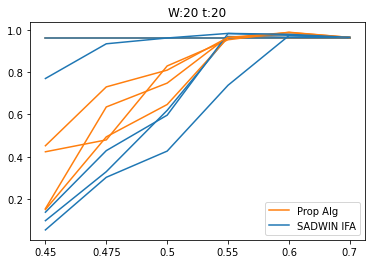

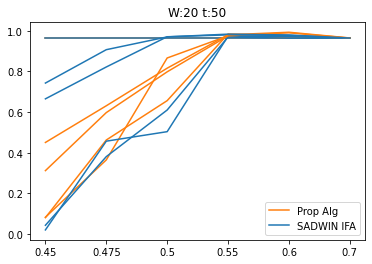

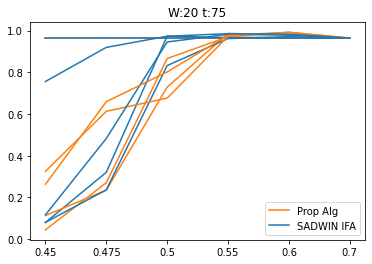

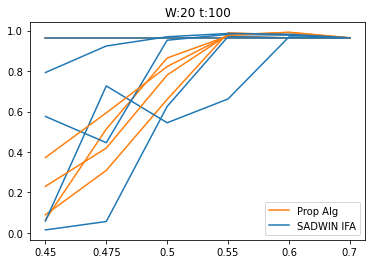

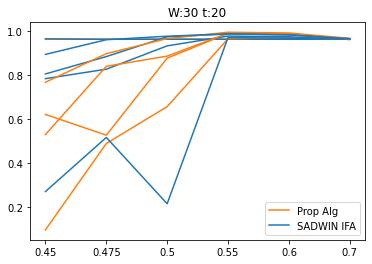

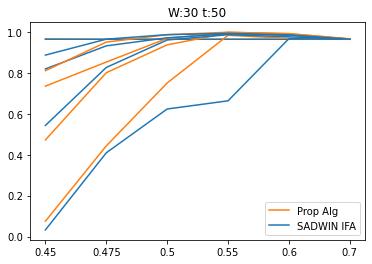

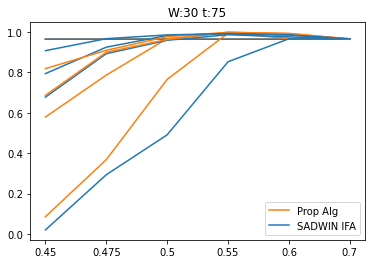

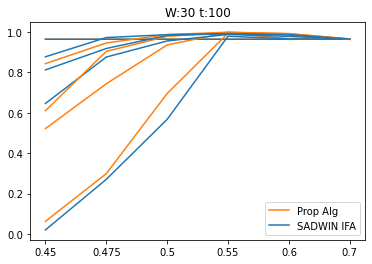

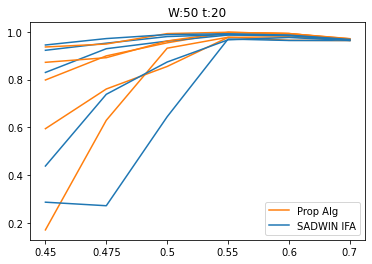

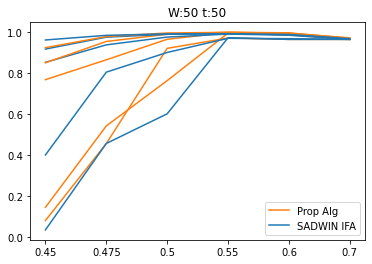

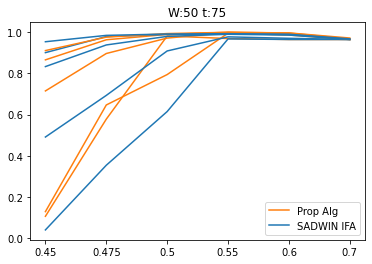

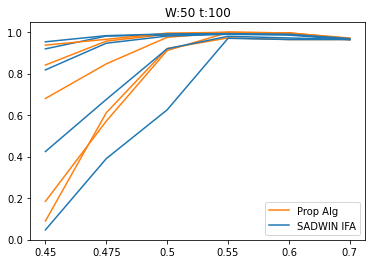

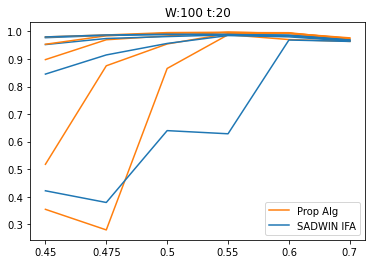

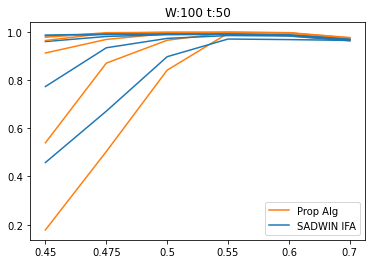

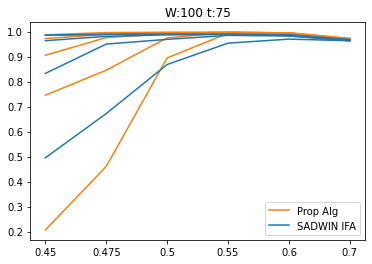

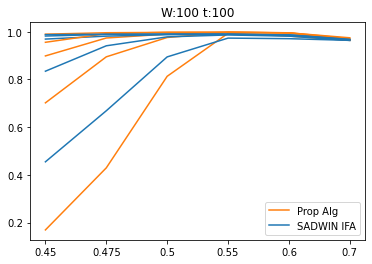

In [29]:
print(thresh_list)
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        plt.figure()
        for cc in range(results.shape[2]):
            result1 = results[aa,bb,cc,:,0,7]
            result2 = results[aa,bb,cc,:,1,7]
            plt.plot(result1,color='tab:orange')
            plt.plot(result2,color='tab:blue')
        plt.title('W:'+str(window_size_list[aa])+
                  ' t:'+str(t_list[bb]))

        plt.legend(['Prop Alg','SADWIN IFA'])
        plt.xticks(list(range(len(result1))),thresh_list)
        plt.show()

# Plot for Subsampling Ratio

[0.45  0.475 0.5   0.55  0.6   0.7  ]


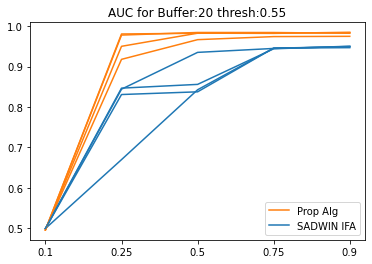

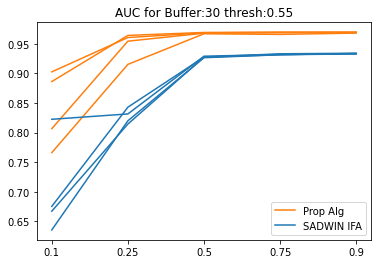

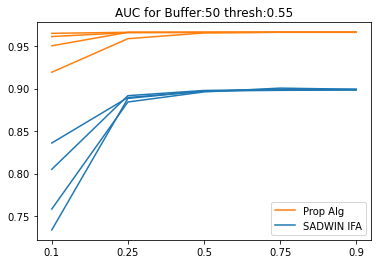

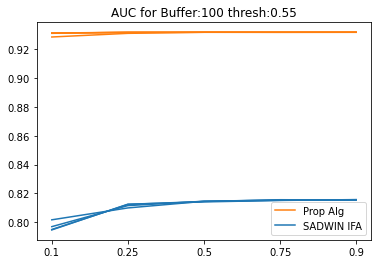

In [27]:
print(thresh_list)
for aa in range(results.shape[0]):
    plt.figure()
    for bb in range(results.shape[1]):
        result1 = results[aa,bb,:,3,0,10]
        result2 = results[aa,bb,:,3,1,10]
        plt.plot(result1,color='tab:orange')
        plt.plot(result2,color='tab:blue')
    plt.title('AUC for Buffer:'+str(window_size_list[aa])+
              ' thresh:'+str(thresh_list[3]))

    plt.legend(['Prop Alg','SADWIN IFA'])
    plt.xticks(list(range(len(result1))),phi_list)
    plt.show()

[0.45  0.475 0.5   0.55  0.6   0.7  ]


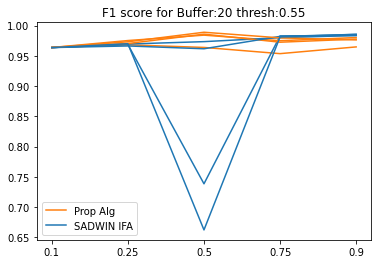

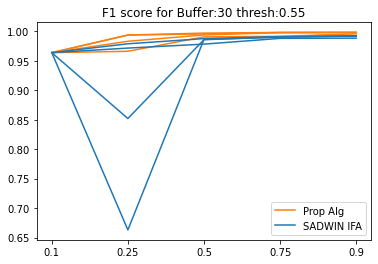

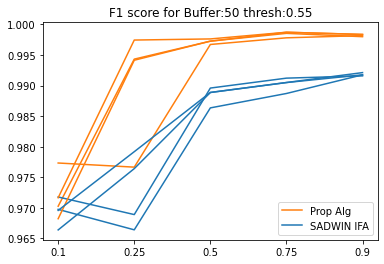

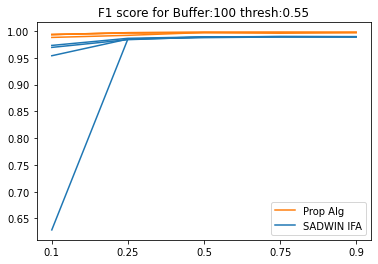

In [28]:
print(thresh_list)
for aa in range(results.shape[0]):
    plt.figure()
    for bb in range(results.shape[1]):
        result1 = results[aa,bb,:,3,0,7]
        result2 = results[aa,bb,:,3,1,7]
        plt.plot(result1,color='tab:orange')
        plt.plot(result2,color='tab:blue')
    plt.title('F1 score for Buffer:'+str(window_size_list[aa])+
              ' thresh:'+str(thresh_list[bb]))

    plt.legend(['Prop Alg','SADWIN IFA'])
    plt.xticks(list(range(len(result1))),phi_list)
    plt.show()

# Plot for Number of Trees

[0.45  0.475 0.5   0.55  0.6   0.7  ]


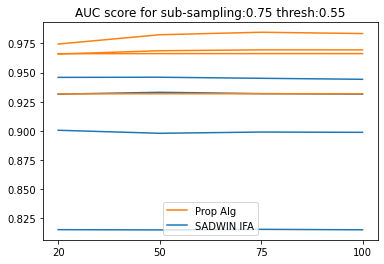

In [25]:
print(thresh_list)
plt.figure()
for aa in range(results.shape[0]):
    result1 = results[aa,:,3,3,0,10]
    result2 = results[aa,:,3,3,1,10]
    plt.plot(result1,color='tab:orange')
    plt.plot(result2,color='tab:blue')
    plt.title('AUC score for sub-sampling:'+str(phi_list[3])+
              ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),t_list)
plt.show()

[0.45  0.475 0.5   0.55  0.6   0.7  ]


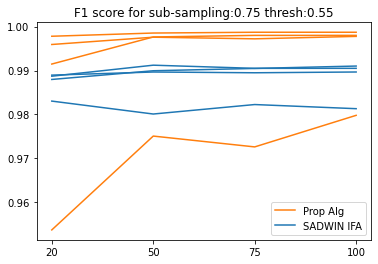

In [26]:
print(thresh_list)
plt.figure()
for aa in range(results.shape[0]):
    result1 = results[aa,:,3,3,0,7]
    result2 = results[aa,:,3,3,1,7]
    plt.plot(result1,color='tab:orange')
    plt.plot(result2,color='tab:blue')
    plt.title('F1 score for sub-sampling:'+str(phi_list[3])+
              ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),t_list)
plt.show()

# Plot for Buffer Size

[ 20  30  50 100]


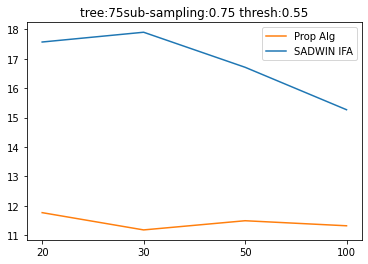

In [23]:
print(window_size_list)
plt.figure()
result1 = results[:,2,3,3,0,11]
result2 = results[:,2,3,3,1,11]
plt.plot(result1,color='tab:orange')
plt.plot(result2,color='tab:blue')
plt.title('tree:'+str(t_list[2])+
          'sub-sampling:'+str(phi_list[3])+
          ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),window_size_list)
plt.show()

[ 20  30  50 100]


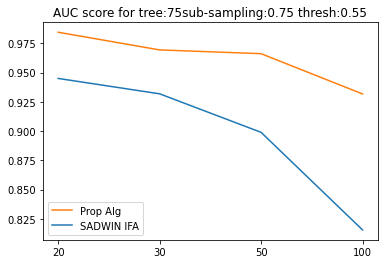

In [24]:
print(window_size_list)
plt.figure()
result1 = results[:,2,3,3,0,10]
result2 = results[:,2,3,3,1,10]
plt.plot(result1,color='tab:orange')
plt.plot(result2,color='tab:blue')
plt.title('AUC score for tree:'+str(t_list[2])+
          'sub-sampling:'+str(phi_list[3])+
          ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),window_size_list)
plt.show()